## Addressing Challenges in Linear Regression

A dataset may face several issues which could make it unsuitable to fit a linear model on it. Some of these issues can be mitigated, while others may require that you rethink your approach.

We will demonstrate problems with scaling, multicollinearity, heteroscedasticity, overfitting, and more. To do this, we will use different datasets, as, if a single dataset faces all these challenges, you may be better off using another model.

Let's start by loading libraries

In [1]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; from matplotlib.ticker import MaxNLocator; import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings; warnings.filterwarnings('ignore')

In [2]:
local=1
aws=0

if local:
  base_path = "/Users/aditikulkarni/Documents/Masters/AI-Projects/04-ML-Models/linear-regression/"
  raw_data =  base_path + "data/raw/"
  processed_data = base_path + "data/processed/"
  models = base_path + "models/"

if aws:
  raw_data = "s3://ml-data-masters/04-ML-Models/data/raw/"
  processed_data = "s3://ml-data-masters/04-ML-Models/data/processed/"
  models = "s3://ml-data-masters/04-ML-Models/models/"


### Scaling and Interpretability
We cannot compare coefficients in linear regression and make claims about which predictors are stronger or weaker unless they are on the same scale. So, rescaling the predictors to a common scale can enable analysis of feature importance. For e.g. weight vs height, one is in kg and another in cm. These are 2 different scales or units and cannot be compared.

We will use a data which contains information about the personalities of various people, with the target being the size of their friends circle.

In [3]:
df_personality = pd.read_csv(raw_data + 'personality_data.csv'); df_personality.head()

,Alone Time Hours,Stage Fear,Social Events,Outside Events,Personality,Friends Circle Size
0,4,No,4,6.0,Extrovert,13
1,9,Yes,0,0.0,Introvert,0
2,9,Yes,1,2.0,Introvert,5
3,0,No,6,7.0,Extrovert,14
4,3,No,9,4.0,Extrovert,8


In [4]:
df_personality.shape

(100, 6)

In [5]:
df_personality = df_personality[['Alone Time Hours', 'Social Events', 'Personality', 'Friends Circle Size']]

We will need to deal with the categorical predictor `'Personality'` and turn it into numeric type. As this is just a binary class, doing this is fairly straightforward: we will assign `'Introvert'` to $0$ and `'Extrovert'` to $1$. Thus, this predictor is now an indicator of extroversion.

The number of hours that a person spends alone, the number of social events they attend, and their personality are all on different scales. We can fit a linear model to predict their friends circle size without scaling to make interpretations from the coefficients, but we will not be able to fairly compare them.

In [6]:
df_personality['Extrovert'] = df_personality['Personality'].replace({'Introvert': 0, 'Extrovert': 1})  # One-hot encoding

In [7]:
X = df_personality[['Alone Time Hours', 'Social Events', 'Extrovert']]  # Predictors
y = df_personality['Friends Circle Size']  # Target

Let's first fit a linear regression model using the unscaled features and examine the coefficients

In [8]:
# Fit linear regression without scaling
model_unscaled = LinearRegression()
model_unscaled.fit(X, y)
coef_df_unscaled = pd.DataFrame({'Feature': X.columns, 'Coefficient': model_unscaled.coef_}); coef_df_unscaled

,Feature,Coefficient
0,Alone Time Hours,-0.186818
1,Social Events,0.028640
2,Extrovert,6.185525


Is it fair to compare the above coefficients if the predictors themselves are not on the same scale?
- Does alone_time_hours has more impact that social event? 

In [9]:
# Predictions and model performance in unscaled case
y_pred_unscaled = model_unscaled.predict(X)
r2_unscaled = r2_score(y, y_pred_unscaled)
mse_unscaled = mean_squared_error(y, y_pred_unscaled)
print(f'R² Score: {r2_unscaled:.4f}'); print(f'MSE: {mse_unscaled:.4f}')

R² Score: 0.6482
MSE: 7.2445


#### 🔹 MinMaxScaler vs StandardScaler

| Aspect                | MinMaxScaler                                                                 | StandardScaler                                                            |
|-----------------------|-------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Formula**           | X' = (X - X_min) / (X_max - X_min)                                           | X' = (X - mean) / std_dev                                                 |
| **What it does**      | Rescales data to a fixed range (default [0, 1], but can be customized).      | Standardizes data to have mean = 0 and std dev = 1.                       |
| **Effect on distribution** | Preserves the shape of the original distribution (just squishes it).    | Shifts & scales data → distribution centered at 0, spread in std devs.    |
| **Sensitive to outliers?** | ✅ Yes (outliers strongly affect min & max).                             | ⚠️ Less sensitive, but mean & std still influenced by outliers.           |
| **Use case**          | Neural nets, KNN, K-means, SVM with RBF kernel (needs bounded features).     | Linear/Logistic Regression, PCA, LDA, SVM (linear kernel).                |


Let's now fit a linear regression model for the same data, but scale all predictors to the interval $[0, 1]$ using **min-max scaling**. Here, the minimum value of a predictor in our training set is represented by $0$ while the maximum is represented by $1$.

In [10]:
# Apply standardisation
# X has all numeric columns
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns); X_scaled.head()

,Alone Time Hours,Social Events,Extrovert
0,0.4,0.4,1.0
1,0.9,0.0,0.0
2,0.9,0.1,0.0
3,0.0,0.6,1.0
4,0.3,0.9,1.0


Now, all the predictors are on the same scale

In [11]:
# Fit linear regression with scaled features
model_scaled = LinearRegression()
model_scaled.fit(X_scaled, y)
coef_df_scaled = pd.DataFrame({'Feature': X_scaled.columns, 'Coefficient': model_scaled.coef_}); coef_df_scaled

,Feature,Coefficient
0,Alone Time Hours,-1.868176
1,Social Events,0.286396
2,Extrovert,6.185525


The coefficient for extroversion did not change because it was already in the $[0, 1]$ interval. Note how the coefficient for `'Alone Time Hours'` and `'Social Events'` have changed.

We can now fairly compare the features using their coefficients. We can see that in terms of importance of the features, `'Extrovert'` $>$ `'Alone Time Hours'` $>$ `'Social Events'`.

In [12]:
# Predictions and model performance in scaled case
y_pred_scaled = model_scaled.predict(X_scaled)
r2_scaled = r2_score(y, y_pred_scaled)
mse_scaled = mean_squared_error(y, y_pred_scaled)
print(f'R² Score: {r2_scaled:.4f}'); print(f'MSE: {mse_scaled:.4f}')

R² Score: 0.6482
MSE: 7.2445


We can see that scaling did not do much for performance. This is expected, as scaling only improves the interpretability of coefficients.

### Multicollinearity
Including too many predictors in a regression model can lead to redundancy among them, resulting in **multicollinearity**. We need diagnostics and techniques like adjusted $R^2$, the variance inflation factor or VIF, and recursive feature elimination or RFE to identify and address these issues.

We'll use the California Housing dataset which is preloaded into `sklearn` for this demonstration

In [13]:
# Load the California Housing dataset which is preloaded into scikit-learn
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns = housing.feature_names)  # Predictors
y = housing.target  # The sale price of the house
print('Shape of original data =', (X.shape[0], X.shape[1] + 1))  # Includes the target feature

Shape of original data = (20640, 9)


In [14]:
# Select a smaller subset of the predictors and a random sample of the entries
X = X[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']].sample(100, random_state = 90)
y = y[X.index]  # Ensure that the entries in y are the same as the corresponding ones in X
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
19174,6.8586,21.0,6.876623,0.974026,400.0,2.597403
19370,5.6445,8.0,7.710526,1.523923,851.0,2.035885
16676,3.0938,34.0,5.719557,1.138376,1155.0,2.130996
11740,3.3802,17.0,5.756560,1.045190,1683.0,2.453353
810,3.8125,35.0,4.902985,0.880597,328.0,2.447761


In [15]:
print('Shape of subset data =', (X.shape[0], X.shape[1] + 1))  # Includes the target feature

Shape of subset data = (100, 7)


Multicollinearity occurs when two or more predictors in a regression model are highly correlated, meaning they provide redundant information about the target's variation. This raises various issues. For instance, small changes in data can cause large changes in coefficient estimates and it can get difficult to isolate the individual effect of each predictor.

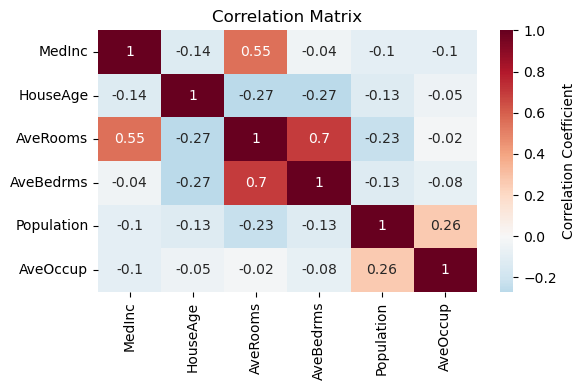

In [16]:
# Create correlation matrix and heatmap
plt.figure(figsize = (6, 4))
sns.heatmap(X.select_dtypes(include = ['number']).corr().round(2), annot = True, cmap = 'RdBu_r', center = 0, cbar_kws = {'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix'); plt.tight_layout();

We can see that `'AveRooms'` and `'AveBedrms'` seem highly correlated. Yet, we will proceed to fitting `LinearRegression()` on all the predictors to study the impact of the inclusion of correlated predictors.

In [17]:
model_all = LinearRegression()
model_all.fit(X, y)
coeff_df = pd.DataFrame({'Feature': X.columns.tolist() + ['Intercept'], 'Coefficient': model_all.coef_.tolist() + [model_all.intercept_]})
display(coeff_df); print('R² =', round(model_all.score(X, y), 3))

,Feature,Coefficient
0,MedInc,0.553739
1,HouseAge,0.017206
2,AveRooms,-0.296688
3,AveBedrms,1.352664
4,Population,-0.000050
5,AveOccup,-0.223763
6,Intercept,0.355313


R² = 0.622


#### Removing Features Based on the Sum of Absolute Correlations

Let's now try to remove predictors based on multicollinearity. For this, let's develop a simple heuristic. For each predictor, we'll calculate the sum of the absolute correlation values with all other predictors, and remove the feature with the highest sum. We'll repeat this process until there is just one feature left.

In [18]:
def correlated_feature_remover(inputdf, target):
    df = inputdf.copy()
    
    # Initial regression model with all predictors
    model = LinearRegression()
    model.fit(df, target)
    
    records = []  # To store iteration number, number of features at iteration, maximum correlation sum, feature to drop, and R-squared before dropping
    iteration = 1  # Iteration number

    while df.shape[1] > 1:
        correlation_matrix = df.corr()
        sum_abs_corr = correlation_matrix.abs().sum()  # No need to exclude self correlation as heuristic is relative
        predictor_to_drop = sum_abs_corr.idxmax()
        max_corr_sum = sum_abs_corr.max()
        r2_before_drop = model.score(df, target)
        records.append({'Iteration': iteration, 'Num_Features': df.shape[1], 'Feature_To_Drop': predictor_to_drop,
                        'Max_Correlation_Sum': round(max_corr_sum, 3), 'R2_Before_Drop': round(r2_before_drop, 3)})
    
        df = df.drop(columns = [predictor_to_drop])
        model.fit(df, target)
        iteration += 1

    # Final iteration with one feature left
    r2_final = model.score(df, target)
    records.append({'Iteration': iteration, 'Num_Features': df.shape[1], 'Feature_To_Drop': None,
                    'Max_Correlation_Sum': 0.0, 'R2_Before_Drop': round(r2_final, 3)})
        
    return pd.DataFrame(records).set_index('Iteration')

In [19]:
correlated_feature_remover(X,y)

,Num_Features,Feature_To_Drop,Max_Correlation_Sum,R2_Before_Drop
Iteration,,,,
1,6,AveRooms,2.775,0.622
2,5,Population,1.614,0.587
3,4,HouseAge,1.455,0.587
4,3,AveOccup,1.183,0.557
5,2,MedInc,1.037,0.484
6,1,None,0.000,0.012


Is our model any good? Should we have stopped dropping features earlier in this process?

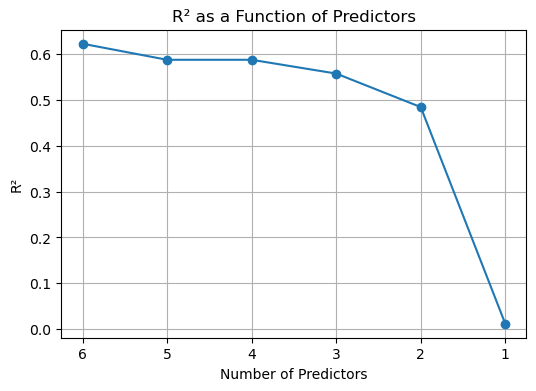

In [20]:
# Visualise the R-squared change
plt.figure(figsize = (6, 4))
plt.plot(correlated_feature_remover(X,y)['Num_Features'], correlated_feature_remover(X,y)['R2_Before_Drop'], marker = 'o')
plt.xlabel('Number of Predictors'); plt.ylabel('R²'); plt.title('R² as a Function of Predictors'); plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True)); plt.gca().invert_xaxis(); plt.grid(True);

Note how $R^2$ always drops as you remove predictors, but some predictors do not offer much in explaining the target feature. $R^2$ only gives an idea about the proportion of variance explained. It always increases with more predictors, even if they are irrelevant.

#### Adjusted $R^2$

Adjusted $R^2$ ($R_{\mathrm{adj}}^2$), on the other hand, penalises the presence of irrelevant predictors. If $n$ is the number of observations, $p$ is the number of predictors, $\text{RSS}$ is the sum of squared residuals, and $\text{TSS}$ is the total sum of squares, we can calculate $R_{\mathrm{adj}}^2$ as

$$R_{\mathrm{adj}}^2 = 1 - \frac{(1-R^2) (n-1)}{n-p-1}$$

As there's no built-in function in `sklearn` to calculate the adjusted $R^2$, we will manually functionalise this formula

In [21]:
def adjusted_r2(r2, n, p): return 1 - (1 - r2) * (n - 1) / (n - p - 1)  # Function to calculate adjusted R²

Let's modify our feature remover to also compute the adjusted $R^2$

In [22]:
def correlated_feature_remover_with_adj_r2(inputdf, target):
    df = inputdf.copy()
    
    # Initial regression model with all predictors
    model = LinearRegression()
    model.fit(df, target)
    
    records = []  # To store iteration number, number of features at iteration, maximum correlation sum, feature to drop, R-squared, and adjusted R-squared before dropping
    iteration = 1  # Iteration number
    n = len(target)  # Number of samples

    while df.shape[1] > 1:
        correlation_matrix = df.corr()
        sum_abs_corr = correlation_matrix.abs().sum()  # No need to exclude self correlation as heuristic is relative
        predictor_to_drop = sum_abs_corr.idxmax()
        max_corr_sum = sum_abs_corr.max()
        r2_before_drop = model.score(df, target)
        adj_r2_before_drop = adjusted_r2(r2_before_drop, n, df.shape[1])
        records.append({'Iteration': iteration, 'Num_Features': df.shape[1], 'Feature_To_Drop': predictor_to_drop,
                        'Max_Correlation_Sum': round(max_corr_sum, 3), 'R2_Before_Drop': round(r2_before_drop, 3),
                        'Adjusted_R2_Before_Drop': round(adj_r2_before_drop, 3)})
    
        df = df.drop(columns = [predictor_to_drop])
        model.fit(df, target)
        iteration += 1

    # Final iteration with one feature left
    r2_final = model.score(df, target)
    adj_r2_final = adjusted_r2(r2_final, n, df.shape[1])
    records.append({'Iteration': iteration, 'Num_Features': df.shape[1], 'Feature_To_Drop': None,
                    'Max_Correlation_Sum': 0.0, 'R2_Before_Drop': round(r2_final, 3),
                    'Adjusted_R2_Before_Drop': round(adj_r2_final, 3)})
        
    return pd.DataFrame(records).set_index('Iteration')

In [23]:
df_feature_remover = correlated_feature_remover_with_adj_r2(X, y)
df_feature_remover

,Num_Features,Feature_To_Drop,Max_Correlation_Sum,R2_Before_Drop,Adjusted_R2_Before_Drop
Iteration,,,,,
1,6,AveRooms,2.775,0.622,0.598
2,5,Population,1.614,0.587,0.565
3,4,HouseAge,1.455,0.587,0.570
4,3,AveOccup,1.183,0.557,0.543
5,2,MedInc,1.037,0.484,0.474
6,1,None,0.000,0.012,0.002


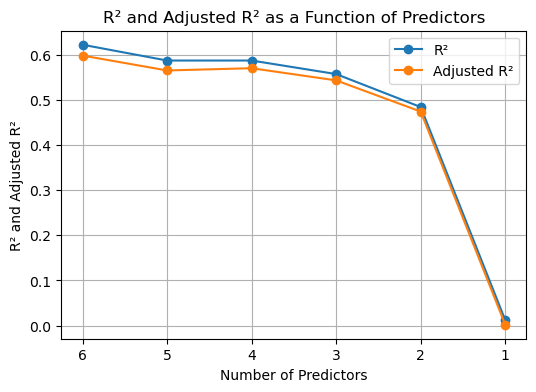

In [24]:
# Visualise the R-squared and adjusted-R-squared change
plt.figure(figsize = (6, 4))
plt.plot(df_feature_remover['Num_Features'], df_feature_remover['R2_Before_Drop'], marker = 'o', label = 'R²')
plt.plot(df_feature_remover['Num_Features'], df_feature_remover['Adjusted_R2_Before_Drop'], marker = 'o', label = 'Adjusted R²')
plt.xlabel('Number of Predictors'); plt.ylabel('R² and Adjusted R²'); plt.title('R² and Adjusted R² as a Function of Predictors'); plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True)); plt.gca().invert_xaxis(); plt.legend(); plt.grid(True);

While adjusted $R^2$ and $R^2$ follow similar trends, adjusted $R^2$ penalises the model for having more predictors, so the separation between the two metrics will be larger for larger number of predictors

#### Variance Inflation Factor
The variance inflation factor (VIF) measures the redundant contribution to target variance prediction due to predictors. For predictor $X_i$, $\mathrm{VIF}_i = \frac{1}{1 - R^2_i}$, where $R^2_i$ is the $R^2$ from regressing $X_i$ on all other predictors.

Let's calculate the VIF using the `variance_inflation_factor()` method from `statsmodels.stats.outliers_influence`

📌 Minimum and Maximum Value of VIF
- ✅ Minimum VIF = 1
- This happens when a feature has no correlation with any other predictor.
- Indicates perfect independence.
- Interpretation: VIF = 1 → No multicollinearity at all.

❌ Maximum VIF = ∞ (infinity)
- VIF grows without bound as multicollinearity increases.
- If a predictor is perfectly collinear with another (e.g., X2 = 2 × X1), then: 1-R2 tends to 1, making denominator 0, and VIF tends to ∞

In [25]:
# Calculate VIF for all predictors
def calculate_vif(dataframe):
    vif_data = []
    for i in range(dataframe.shape[1]):
        vif_value = variance_inflation_factor(dataframe.values, i)
        vif_data.append({'Predictor': dataframe.columns[i], 'VIF': vif_value})
    return pd.DataFrame(vif_data)

In [26]:
# Calculate VIF for original dataset
vif_df = calculate_vif(X)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.round(3).set_index('Predictor')

,VIF
Predictor,
AveRooms,55.297
AveBedrms,46.475
MedInc,10.397
AveOccup,8.269
HouseAge,5.379
Population,4.539


Typically, the following guidelines are recommended when working with VIF values
- $\text{VIF} = 1$ → No correlation between this predictor and others
- $1 < \text{VIF} < 5$ → Very mildly correlated and generally acceptable
- $5 \leq \text{VIF} < 10$ → Moderately correlated and indicates potential multicollinearity issues
- $\text{VIF} \geq 10$ → Strongly correlated and may necessitate treatment of this predictor

In [ ]:
# Visualise VIF values
def plot_vif(df):
    plt.figure(figsize = (6, 4))
    colors = ['red' if vif > 10 else 'yellow' if vif > 5 else 'green' for vif in df['VIF']]; 
    bars = plt.bar(df['Predictor'], df['VIF'], color = colors, alpha = 0.7); 
    plt.axhline(y = 5, color = 'orange', linestyle = '--', label = 'VIF = 5 (Moderate threshold)'); 
    plt.axhline(y = 10, color = 'red', linestyle = '--', label = 'VIF = 10 (High threshold)'); plt.xlabel(' '); plt.ylabel('VIF Value'); plt.title('Variance Inflation Factor by Predictor'); plt.xticks(rotation = 45); plt.legend(); plt.grid(True, alpha = 0.3); plt.tight_layout();

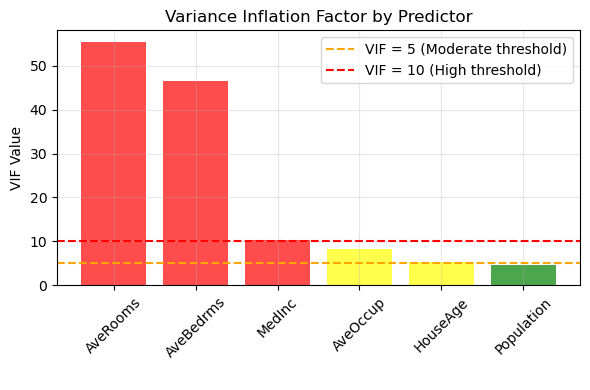

In [28]:
plot_vif(vif_df)

If a predictor has a high VIF, it can be predicted with high accuracy from the other predictors. It is redundant, because most of its information is already contained in the other predictors.

Let’s pick some of the high-VIF predictors and try to predict them using the remaining predictors

In [29]:
# Fit linear regression with a predictor as a target feature and other features (except the actual target) as predictors 
def feature_r2(df, target_feature):
    X = df.drop(columns = [target_feature])  # Remove one predictor
    y = df[target_feature]  # Set it as the target    
    lr = LinearRegression()
    lr.fit(X, y)
    return r2_score(y, lr.predict(X))

In [30]:
high_vif_features = ['AveRooms', 'AveBedrms', 'MedInc']  # Check R² for high-VIF features
for f in high_vif_features: print(f'R² for {f} ~ other predictors: {feature_r2(X, f):.3f}')

R² for AveRooms ~ other predictors: 0.840
R² for AveBedrms ~ other predictors: 0.766
R² for MedInc ~ other predictors: 0.683


This means that `'AveRooms'` and `'AveBedrms'` can easily be predicted from the other predictors (likely, they are predicting each-other)

In [31]:
X_vif_reduced = X.drop('AveRooms', axis = 1)  # Remove the feature with highest VIF
vif_df_reduced = calculate_vif(X_vif_reduced)  # Recalculate the VIFs of the remaining predictors
vif_df_reduced = vif_df_reduced.sort_values('VIF', ascending = False)
vif_df_reduced.round(3).set_index('Predictor')

,VIF
Predictor,
AveBedrms,9.572
AveOccup,8.153
HouseAge,4.850
MedInc,4.143
Population,3.901


We can see that the VIF scores have greatly improved

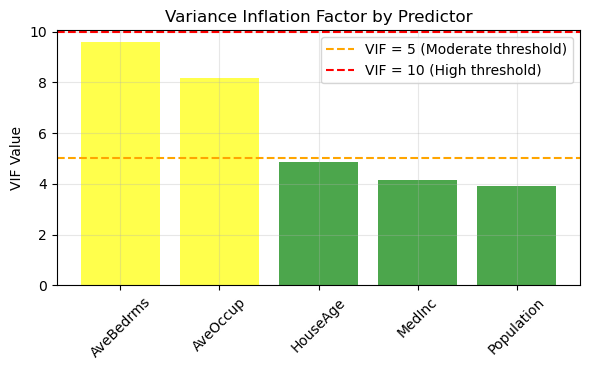

In [32]:
plot_vif(vif_df_reduced)

In [33]:
# Compare model performance
model_original = LinearRegression().fit(X, y)
model_vif_reduced = LinearRegression().fit(X_vif_reduced, y)
r2_original = model_original.score(X, y)
r2_reduced = model_vif_reduced.score(X_vif_reduced, y)
adj_r2_original = adjusted_r2(r2_original, len(X), X.shape[1])
adj_r2_reduced = adjusted_r2(r2_reduced, len(X_vif_reduced), X_vif_reduced.shape[1])

print('Model Performance Comparison'); print(f'Original model: R²: {r2_original:.4f}, Adj R²: {adj_r2_original:.4f}'); print(f'VIF-reduced model: - R²: {r2_reduced:.4f}, Adj R²: {adj_r2_reduced:.4f}')

Model Performance Comparison
Original model: R²: 0.6224, Adj R²: 0.5980
VIF-reduced model: - R²: 0.5874, Adj R²: 0.5654


The drops in $R^2$ and adjusted $R^2$ are expected, but we need to take a call on whether we want to retain a highly correlated predictor or not based on business and domain knowledge and also considering factors such as training time and model complexity

#### Recursive Feature Elimination
Recursive feature elimination (RFE) is a systematic approach to feature selection that iteratively fits a model with features, ranks the features by importance, eliminates the least important feature, and repeats until a fixed number of features remain

Let's return to our original data with all features intact and apply RFE to remove redundant features

In [34]:
model = LinearRegression()
model.fit(X, y)
rfe = RFE(estimator = model, n_features_to_select = 5)  # RFE with LR
rfe.fit(X, y)
selected = pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_, 'Coefficient': model.coef_.round(3)}); selected

,Feature,Selected,Coefficient
0,MedInc,True,0.554
1,HouseAge,True,0.017
2,AveRooms,True,-0.297
3,AveBedrms,True,1.353
4,Population,False,-0.000
5,AveOccup,True,-0.224


`Population` was discarded by RFE because its contribution to predicting the target is weak compared to other features. Let's compare how the RFE model compares with the non-RFE one.

In [35]:
X_rfe = X.loc[:, rfe.support_]
model.fit(X_rfe, y)
y_pred = model.predict(X_rfe)
r2_rfe = r2_score(y, y_pred)
print('Model with all features has an R² of', np.round(r2_score(y, model.fit(X, y).predict(X)), 3)); print('Model with RFE-selected 5 features has an R² of', np.round(r2_rfe, 3))

Model with all features has an R² of 0.622
Model with RFE-selected 5 features has an R² of 0.621


The $R^2$ value has not changed much even after dropping a feature, so that's good. Typically, we can evaluate $R^2$ iteratively and choose a fair number of predictors to retain by analysing how $R^2$ drops in each iteration.

In [36]:
def iterative_rfe_analysis(X, y):
    n_samples = len(X)  # Number of data points
    model = LinearRegression()
    rfe_records = []  # To store details of each feature drop

    # Start with all features and drop one at each iteration
    for iteration in range(X.shape[1], 0, -1):
        rfe = RFE(estimator = model, n_features_to_select = iteration)
        rfe.fit(X, y)
        X_selected = X[X.columns[rfe.support_].tolist()]
        model.fit(X_selected, y)
        r2 = model.score(X_selected, y)
        adj_r2 = adjusted_r2(r2, n_samples, X_selected.shape[1])
        rfe_records.append({'Iteration': X.shape[1] - iteration + 1, 'Num_Features': X_selected.shape[1],
                            'R2': round(r2, 3), 'Adjusted_R2': round(adj_r2, 3)})
        
    return pd.DataFrame(rfe_records).set_index('Iteration')

In [37]:
iterative_rfe_analysis(X, y)

,Num_Features,R2,Adjusted_R2
Iteration,,,
1,6,0.622,0.598
2,5,0.621,0.601
3,4,0.589,0.572
4,3,0.540,0.525
5,2,0.484,0.474
6,1,0.012,0.002


As expected, both $R^2$ and adjusted $R^2$ decrease with fewer predictors, but the drop in $R^2$ is sharper than that of the adjusted $R^2$ drop

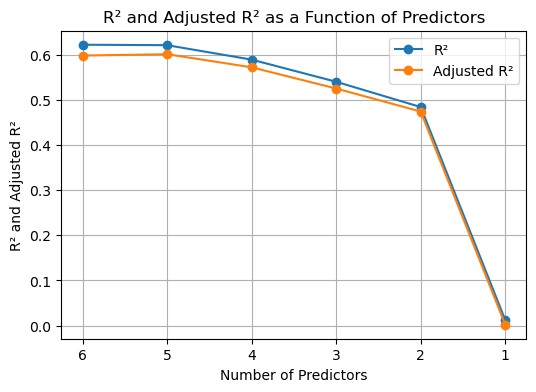

In [38]:
# Visualise the R-squared and adjusted-R-squared change
plt.figure(figsize = (6, 4))
plt.plot(iterative_rfe_analysis(X, y)['Num_Features'], iterative_rfe_analysis(X, y)['R2'], marker = 'o', label = 'R²')
plt.plot(iterative_rfe_analysis(X, y)['Num_Features'], iterative_rfe_analysis(X, y)['Adjusted_R2'], marker = 'o', label = 'Adjusted R²')
plt.xlabel('Number of Predictors'); plt.ylabel('R² and Adjusted R²'); plt.title('R² and Adjusted R² as a Function of Predictors'); plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True)); plt.gca().invert_xaxis(); plt.legend(); plt.grid(True);

While adjusted $R^2$ and $R^2$ follow similar trends, the separation becomes minimal at around four or three predictors. If the $R^2$ for these predictors is acceptable to the business use-case, then it might be a good number of predictors to retain.

### Categorical Predictors and VIF
Categorical variables can significantly distort the variance inflation factor values due to one-hot encoding. When we convert categorical variables into multiple dummy variables, these dummies are inherently correlated because they represent partitions of the same underlying feature. This correlation inflates VIF values, which must be interpreted carefully in the context of multicollinearity assessment.

We'll use seaborn's built-in `'tips'` dataset, which contains information about restaurant bills and tips

This dataset includes
- **Numeric predictors:** `'total_bill'`, `'size'` (party size)
- **Categorical predictors:** `'sex'`, `'smoker'`, `'day'`, `'time'`
- **Target variable:** `'tip'`

In [39]:
# Load the tips dataset
tips = sns.load_dataset('tips'); tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [40]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [41]:
tips['smoker'].value_counts()  # Distribution of smokers in the dataset

smoker
No     151
Yes     93
Name: count, dtype: int64

First, let's compute VIF values using only the **continuous numerical** predictors

In [42]:
X_numeric_only = tips[['total_bill', 'size']]  # Numeric features only

In [43]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [44]:
calculate_vif(X_numeric_only)  # VIF for numeric predictors

,Feature,VIF
0,total_bill,8.684373
1,size,8.684373


Now we'll encode the categorical `'smoker'` variable using one-hot encoding

In [45]:
# Create dummy variables for 'smoker' (drop first category to avoid dummy trap)
smoker_dummies = pd.get_dummies(tips['smoker'], prefix = 'smoker', drop_first = True)
smoker_dummies.sample(5, random_state = 0)

,smoker_No
64,True
63,False
55,True
111,True
225,False


The level `'smoker_No'` has been taken as the reference category by default due to alphanumeric reasons. So, a true value here indicates that the person is not a smoker while a false value indicates that they are. The `drop_first` argument drops the first level from a categorical predictor. For example, from the levels $[l_1, l_2, ... , l_n]$, if the levels $[l_2, ... , l_n]$ are all `False`, then $l_1$ will be automatically `True`.

In [46]:
# Combine numeric features with categorical dummies
X_with_categorical = pd.concat([X_numeric_only, smoker_dummies], axis = 1)
X_with_categorical.sample(5, random_state = 0)

,total_bill,size,smoker_No
64,17.59,3,True
63,18.29,4,False
55,19.49,2,True
111,7.25,1,True
225,16.27,2,False


Now let's compute VIF values for the above set of features. Before we do that, we need to convert the boolean feature into a numerical data type because `variance_inflation_factor()` expects only numeric columns.

In [47]:
X_with_categorical = X_with_categorical.astype(float)  # Ensure all columns are float
calculate_vif(X_with_categorical)  # Calculate VIF

,Feature,VIF
0,total_bill,8.799990
1,size,10.997729
2,smoker_No,2.456009


In [48]:
# Comparing the VIFs in different cases
print('Numerical predictors')
for _, row in calculate_vif(X_numeric_only).iterrows(): print(f'  {row['Feature']}: {row['VIF']:.2f}')
print('\nNumerical and categorical predictors')
for _, row in calculate_vif(X_with_categorical).iterrows(): print(f'  {row['Feature']}: {row['VIF']:.2f}')

Numerical predictors
  total_bill: 8.68
  size: 8.68

Numerical and categorical predictors
  total_bill: 8.80
  size: 11.00
  smoker_No: 2.46


Let's add another categorical variable `'day'` to our analysis

In [49]:
tips['day'].unique()  # Number of levels in the feature

['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']

In [50]:
# One-hot encoding and preparing the feature set
day_dummies = pd.get_dummies(tips['day'], prefix = 'day', drop_first = True)
X_multiple_categorical = pd.concat([X_numeric_only, smoker_dummies, day_dummies], axis = 1)
X_multiple_categorical = X_multiple_categorical.astype(float)
X_multiple_categorical.sample(5, random_state = 0)

,total_bill,size,smoker_No,day_Fri,day_Sat,day_Sun
64,17.59,3.0,1.0,0.0,1.0,0.0
63,18.29,4.0,0.0,0.0,1.0,0.0
55,19.49,2.0,1.0,0.0,0.0,1.0
111,7.25,1.0,1.0,0.0,1.0,0.0
225,16.27,2.0,0.0,1.0,0.0,0.0


Notice how we have three dummy variables for Friday, Saturday, and Sunday. If all of these are `False` or `0.0`, it means the day is Thursday.

In [51]:
calculate_vif(X_multiple_categorical)  # Compute VIF

,Feature,VIF
0,total_bill,9.293362
1,size,11.633307
2,smoker_No,2.566060
3,day_Fri,1.172817
4,day_Sat,2.048594
5,day_Sun,2.142137


In [52]:
# Comparing the VIFs in different cases
print('Numerical predictors')
for _, row in calculate_vif(X_numeric_only).iterrows(): print(f'  {row['Feature']}: {row['VIF']:.2f}')
print('\nNumerical and categorical predictors')
for _, row in calculate_vif(X_with_categorical).iterrows(): print(f'  {row['Feature']}: {row['VIF']:.2f}')
print('\nNumerical and more categorical predictors')
for _, row in calculate_vif(X_multiple_categorical).iterrows(): print(f'  {row['Feature']}: {row['VIF']:.2f}')

Numerical predictors
  total_bill: 8.68
  size: 8.68

Numerical and categorical predictors
  total_bill: 8.80
  size: 11.00
  smoker_No: 2.46

Numerical and more categorical predictors
  total_bill: 9.29
  size: 11.63
  smoker_No: 2.57
  day_Fri: 1.17
  day_Sat: 2.05
  day_Sun: 2.14


We can see that the addition of more categorical levels leads to inflation in the VIFs of numerical features. So, VIF values for categorical dummies should not be over-interpreted in isolation. Categorical predictors introduce structural correlation, which can inflate VIF values. They reflect the encoding structure, not problematic collinearity. The main concern lies with numeric predictors, while categorical variables should be assessed as groups rather than as separate variables, if at all possible.

### Overfitting
A model can sometimes learn too much from the training data, including random noise. This makes it perform well on the data it has seen but poorly on new data. This is called **overfitting**.

For this demonstration, we will create a synthetic dataset in which the target `y` depends on only predictor `x1`, but also add random noise predictors `x2` ... `x20`, that are irrelevant for prediction. This will help us demonstrate how overfitting arises when we include unnecessary predictors.

In [53]:
np.random.seed(42)  # Set a random seed so that this experiment is replicable
X1 = np.random.uniform(-3, 3, 100).reshape(-1, 1)  # True predictor
y = 4 * X1 + np.random.randn(100, 1) * 2   # True relation
noise = np.random.randn(100, 19)  # Add irrelevant features as noise (19 noisy predictors)
X = np.hstack([X1, noise])

We will need to split our data into training and testing splits for our experiment. We will use `train_test_split()` from `sklearn.model_selection` to achieve this.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)  # Train-test split

We will compare our model's performance for only the true feature, and then progressively for $5$, $10$, $15$, and $20$ noisy features

In [55]:
def evaluate_model(X_train_sub, X_test_sub, y_train, y_test, label):
    model = LinearRegression()
    model.fit(X_train_sub, y_train)
    y_train_pred = model.predict(X_train_sub)
    y_test_pred = model.predict(X_test_sub)
    model_fit_metrics = {'Model': label, 'Train MSE': round(mean_squared_error(y_train, y_train_pred), 3),
                         'Test MSE': round(mean_squared_error(y_test, y_test_pred), 3),
                         r'Train $R^2$': round(r2_score(y_train, y_train_pred), 3),
                         r'Test $R^2$': round(r2_score(y_test, y_test_pred), 3)}
    return model_fit_metrics

In [56]:
# Progressive models using a loop
results = []
for i in range(0, 21, 5):  # 0, 5, 10, 15, 20 noisy features
    if i == 0:
        desc = 'x1 (true predictor)'
        X_train_subset = X_train[:, [0]]
        X_test_subset = X_test[:, [0]]
    else:
        desc = f'x1 + {i} noisy features'
        X_train_subset = X_train[:, :i+1]
        X_test_subset = X_test[:, :i+1]

    results.append(evaluate_model(X_train_subset, X_test_subset, y_train, y_test, desc))
    
results_df = pd.DataFrame(results); results_df

,Model,Train MSE,Test MSE,Train $R^2$,Test $R^2$
0,x1 (true predictor),3.116,3.516,0.938,0.917
1,x1 + 5 noisy features,2.874,3.642,0.943,0.914
2,x1 + 10 noisy features,2.391,3.354,0.953,0.921
3,x1 + 15 noisy features,2.298,3.317,0.954,0.922
4,x1 + 20 noisy features,2.234,3.381,0.956,0.920


Notice how test performance deteriorates as we add more irrelevant features, while training performance improves

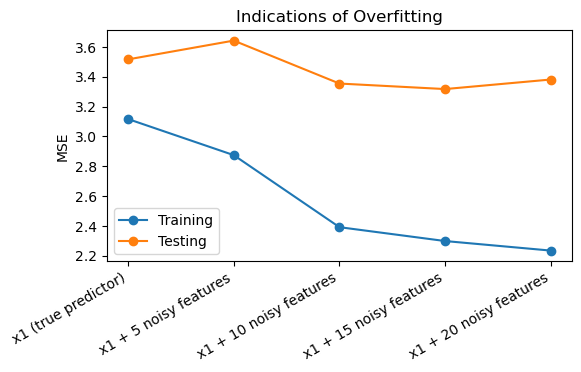

In [57]:
plt.figure(figsize = (6, 3))
plt.plot(results_df['Model'], results_df['Train MSE'], marker = 'o', label = 'Training')
plt.plot(results_df['Model'], results_df['Test MSE'], marker = 'o', label = 'Testing')
plt.xticks(rotation = 30, ha = 'right'); plt.ylabel('MSE'); plt.title('Indications of Overfitting'); plt.legend();

When we add irrelevant predictors, the true predictor (`x1`) should ideally carry the model and the noisy features should have coefficients close to 0, but this isn't always the case due to overfitting. The variance in the irrelevant predictors is used by the model to explain portions of the target variance, hence affecting the true predictor's coefficient.

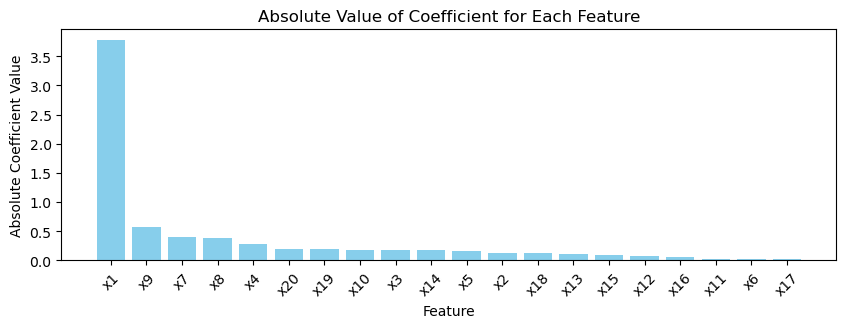

In [58]:
# Visualising the coefficient magnitude for all predictors
# These are comparable because they are on the same scale
model_full = LinearRegression()
model_full.fit(X_train, y_train)
coeffs = pd.DataFrame({'Feature': [f'x{i+1}' for i in range(X_train.shape[1])],  'AbsCoefficient': np.abs(model_full.coef_.flatten())})
coeffs_sorted = coeffs.sort_values(by = 'AbsCoefficient', ascending = False)  # Sort by absolute coefficient value
plt.figure(figsize = (10, 3))
plt.bar(coeffs_sorted['Feature'], coeffs_sorted['AbsCoefficient'], color = 'skyblue')
plt.xlabel('Feature'); plt.ylabel('Absolute Coefficient Value'); plt.title('Absolute Value of Coefficient for Each Feature'); plt.xticks(rotation = 45);

Here, the model has mostly ignored the noise, with the coefficients of its features set close to $0$. Still, even small effects can accumulate, so removing noisy features would make the model train faster and perform better.

### Heteroscedasticity
Residuals or errors indicate how well the model fits the data. Ideally, residuals should scatter randomly around zero with constant variance. Systematic patterns in residuals signal a violation of model assumptions. A common issue is **heteroscedasticity**, when the variance of residuals is not constant across prediction ranges.

To demonstrate non-normal errors, we will create a synthetic heteroscedastic data following $y = 3X + \text{noise} \times X$, where the error variance is not constant

In [59]:
X = np.linspace(1, 10, 100).reshape(-1, 1)  # Generate heteroscedastic data
noise = np.random.randn(100, 1)  # Generate random noise
y = 3 * X + noise * X

In [60]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred
rmse = np.sqrt(mean_squared_error(y, y_pred))
print('RMSE:', round(rmse, 3))

RMSE: 5.73


Let's visualise our residuals

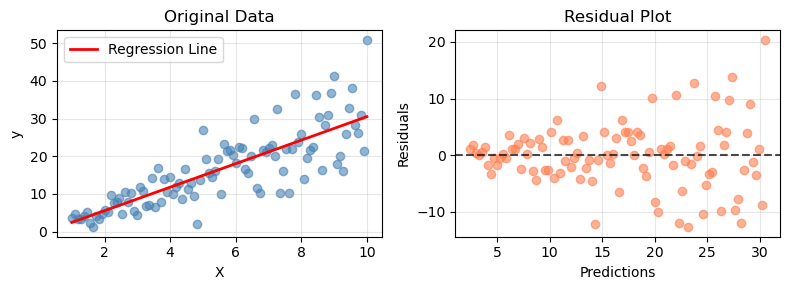

In [61]:
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)  # Raw data with regression line
plt.scatter(X, y, alpha = 0.6, color = 'steelblue'); X_line = np.linspace(X.min(), X.max(), 100); y_line = model.predict(X_line.reshape(-1, 1))
plt.plot(X_line, y_line, 'r-', linewidth = 2, label = 'Regression Line'); plt.xlabel('X'); plt.ylabel('y'); plt.title('Original Data'); plt.legend(); plt.grid(True, alpha = 0.3)
plt.subplot(1, 2, 2)  # Residual plot
plt.scatter(y_pred, residuals, alpha = 0.6, color = 'coral'); plt.axhline(y = 0, color = 'black', linestyle = '--', alpha = 0.7); plt.xlabel('Predictions'); plt.ylabel('Residuals'); plt.title('Residual Plot'); plt.grid(True, alpha = 0.3); plt.tight_layout();

The residual plot shows a funnel shaped pattern, indicating heteroscedasticity where error variance is not constant. This can bias standard errors, making model inferences misleading even if the overall fit appears good.

#### Transforming the Target Variable
We can transform the target variable to stabilise variance in several ways. In this case, we will use the log transformation, as it is good for right-skewed data.

In [62]:
y_log = np.log(y)  # Apply log transformation on target
model_log = LinearRegression()  # Model fit on transformed target
model_log.fit(X, y_log)
y_pred_log = model_log.predict(X)
residuals_log = y_log - y_pred_log
rmse_log = np.sqrt(mean_squared_error(y_log, y_pred_log))
print('RMSE after log-transform:', round(rmse_log, 3))

RMSE after log-transform: 0.415


The scale of errors has changed, let's compare the $R^2$ score for both cases

In [63]:
r2, rmse = r2_score(y, y_pred), np.sqrt(mean_squared_error(y, y_pred))
print(f'Original has R² = {r2:.3f} and RMSE = {rmse:.3f}')

r2_log, rmse_log = r2_score(y_log, y_pred_log), np.sqrt(mean_squared_error(y_log, y_pred_log))
print(f'Log-transformed model has R² = {r2_log:.3f} and RMSE = {rmse_log:.3f}')

Original has R² = 0.671 and RMSE = 5.730
Log-transformed model has R² = 0.682 and RMSE = 0.415


In this case, the transformation seems to have improved the model performance. Sometimes, a small drop in performance is also acceptable if residuals become more homoscedastic, improving reliability of statistical inference.

Let's now revisit our residual plots for the original as well as transformed data

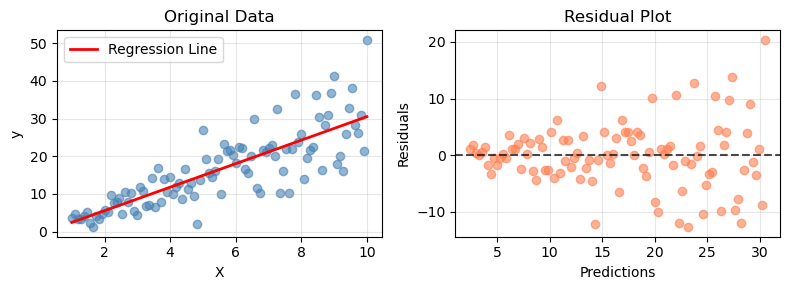

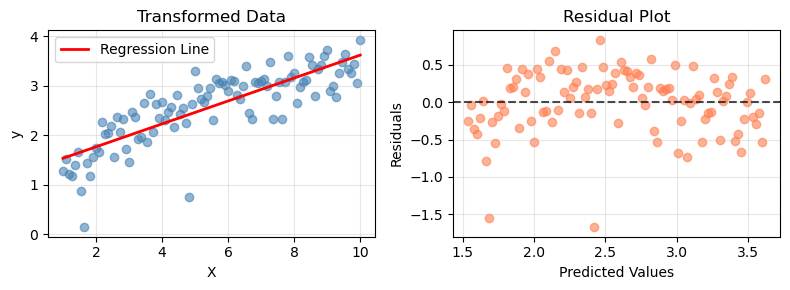

In [64]:
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)  # Raw data with regression line
plt.scatter(X, y, alpha = 0.6, color = 'steelblue'); X_line = np.linspace(X.min(), X.max(), 100); y_line = model.predict(X_line.reshape(-1, 1))
plt.plot(X_line, y_line, 'r-', linewidth = 2, label = 'Regression Line'); plt.xlabel('X'); plt.ylabel('y'); plt.title('Original Data'); plt.legend(); plt.grid(True, alpha = 0.3)
plt.subplot(1, 2, 2)  # Residual plot
plt.scatter(y_pred, residuals, alpha = 0.6, color = 'coral'); plt.axhline(y = 0, color = 'black', linestyle = '--', alpha = 0.7); plt.xlabel('Predictions'); plt.ylabel('Residuals'); plt.title('Residual Plot'); plt.grid(True, alpha = 0.3); plt.tight_layout();

plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)  # Raw data with regression line for log-transformed target
plt.scatter(X, y_log, alpha = 0.6, color = 'steelblue'); X_line, y_line = np.linspace(X.min(), X.max(), 100), model_log.predict(X_line.reshape(-1, 1))
plt.plot(X_line, y_line, 'r-', linewidth = 2, label = 'Regression Line'); plt.xlabel('X'); plt.ylabel('y'); plt.title('Transformed Data'); plt.legend(); plt.grid(True, alpha = 0.3)
plt.subplot(1, 2, 2)  # Residual plot
plt.scatter(y_pred_log, residuals_log, alpha = 0.6, color = 'coral'); plt.axhline(y = 0, color = 'black', linestyle = '--', alpha = 0.7); plt.xlabel('Predicted Values'); plt.ylabel('Residuals'); plt.title('Residual Plot'); plt.grid(True, alpha = 0.3); plt.tight_layout();

We can see that the log-transformed data has less obvious patterns. While this does not fully treat the problem, it is an improvement on the original model.

----
## Address the challenge of less data for training

# Hold-Out Validation vs Cross-Validation

| Aspect                     | Hold-Out Validation                                                                 | Cross-Validation (e.g., k-Fold)                                                                 |
|-----------------------------|--------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| **Definition**             | Split dataset into a single **train/test (or train/validation/test)** partition.     | Split dataset into **k folds**; rotate so each fold is used once as validation and rest as training. |
| **Number of splits**       | Just 1 split.                                                                        | k splits (commonly 5 or 10).                                                                    |
| **Data usage**             | Only part of the data used for validation, rest for training.                        | Every sample is used for training (k−1 times) and validation (1 time).                          |
| **Performance estimate**   | Depends heavily on the chosen split → higher variance.                               | More stable estimate (averaged across folds) → lower variance.                                   |
| **Bias**                   | May suffer from bias if the split is not representative.                             | Less biased since results are averaged over multiple splits.                                     |
| **Variance**               | Higher (results change if you change the split).                                     | Lower (averaging smooths out randomness of split).                                              |
| **Efficiency**             | Very fast (train model once).                                                        | Slower (train model k times).                                                                   |
| **Computation cost**       | Low.                                                                                 | Higher (multiplies training cost by k).                                                         |
| **When to use**            | Large datasets where one split is representative.                                    | Small/medium datasets where reliable performance estimate is needed.                            |
| **Overfitting risk check** | Less reliable (a single split may hide overfitting).                                 | More reliable (tests model on multiple unseen subsets).                                          |
| **Typical ratios**         | Common: 70/30, 80/20, or 60/20/20 (train/val/test).                                  | Common: k=5 or k=10 folds.                                                                      |
| **Example (1000 samples)** | 800 train, 200 test (fixed).                                                         | For k=5: 5 runs of (800 train, 200 test); every sample used once for testing.                   |


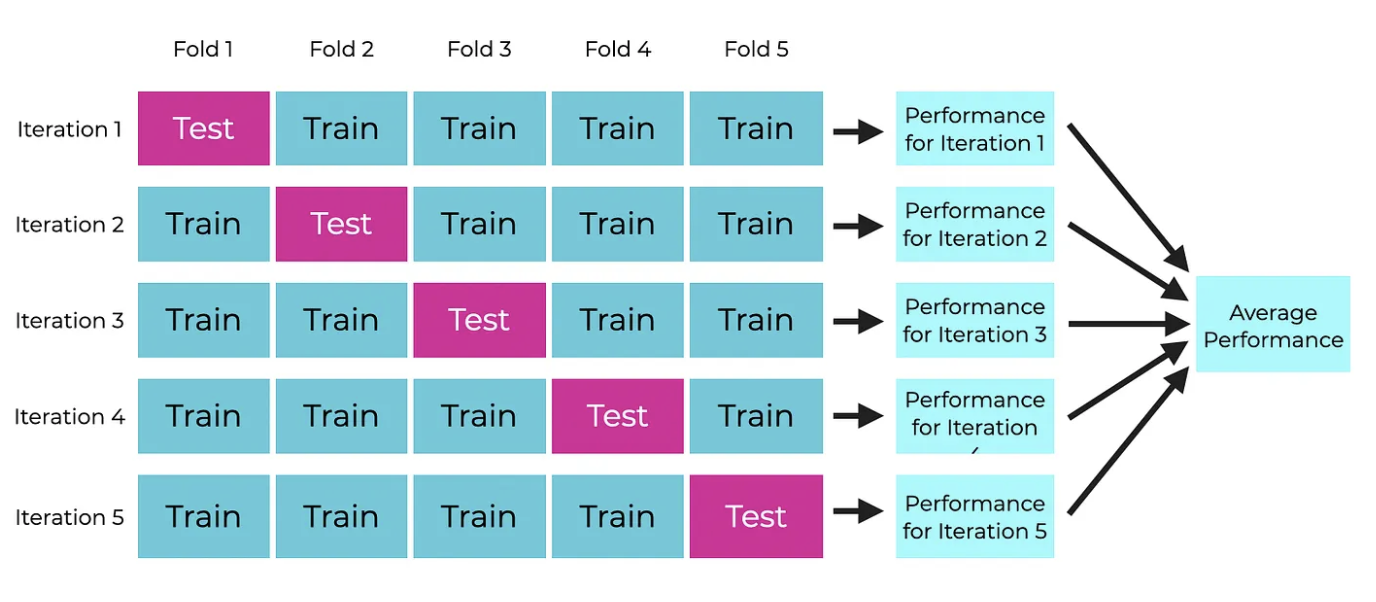

# Comparison: Leave-One-Out, Leave-p-Out, Stratified k-Fold Validation

| Aspect                  | Leave-One-Out (LOO)                                              | Leave-p-Out (LpO)                                                          | Stratified k-Fold                                                         |
|--------------------------|------------------------------------------------------------------|----------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Definition**           | Each split leaves **1 sample** out as validation, rest for training. | Each split leaves **p samples** out as validation, rest for training.        | Dataset split into **k folds**, each fold used once for validation.       |
| **Number of splits**     | Equal to number of samples (N).                                  | Equal to number of all possible p-sized subsets (very large).                | k splits (e.g., 5 or 10).                                                 |
| **Validation size**      | 1 sample per iteration.                                          | p samples per iteration.                                                     | 1/k of dataset per iteration.                                             |
| **Training size**        | N−1 samples per iteration.                                       | N−p samples per iteration.                                                   | (k−1)/k of dataset per iteration.                                         |
| **Bias**                 | Low bias (almost full dataset used for training each time).      | Low bias (similar to LOO, but depends on p).                                 | Depends on k; larger k = lower bias.                                      |
| **Variance**             | High variance (since training sets are very similar).            | Still high if p small; variance decreases as p increases.                     | Lower variance (averaged over folds).                                     |
| **Computation cost**     | Very expensive (train model N times).                            | Extremely expensive (train model for every p-combination).                    | Reasonable (train model k times).                                         |
| **When to use**          | Very small datasets (need to maximize training data).            | Rare in practice (too costly except for tiny datasets).                       | Most common validation method in practice.                                |
| **Special feature**      | Deterministic, no randomness.                                    | Generalization of LOO (p=1 case).                                            | **Stratified** ensures class proportions preserved in each fold.          |
| **Example (N=100)**      | 100 splits → 99 train, 1 test each.                              | For p=2: C(100,2)=4950 splits → 98 train, 2 test each.                        | For k=5: 5 splits → 80 train, 20 test each.                               |


**Key takeaways:**
- LOO → good for tiny datasets but expensive.
- LpO → theoretical generalization but rarely used due to combinatorial explosion.
- Stratified k-Fold → practical choice, balances efficiency and reliability, and handles imbalanced classes well.

**Class Imbalance Problem**
- Suppose you’re predicting a rare disease:
    - Dataset = 1000 patients → 950 healthy (class 0), 50 sick (class 1).
    - Only 5% positives.

- If you split the dataset randomly, here’s what can happen:
    - Train set might end up with only 30 sick patients.
    - Test set might end up with only 2 sick patients (or even 0!).

👉 This makes the model’s training biased and evaluation unreliable, since the distribution no longer matches the real-world problem.

**What Stratification Does**
- Stratified splitting ensures that the class proportions (positive vs negative) in each split (train/test/validation) are the same as in the full dataset.
- In the disease example (5% positive):
    - Train set will have 5% positives.
    - Test set will also have 5% positives.
- So both subsets mirror the original distribution.

**Why It’s Important**
- Fair Training
    - Model sees examples of both majority and minority classes in the right proportion.
    - Prevents a training set with too few (or zero) minority samples.

- Fair Evaluation
    - Test set reflects the true class imbalance.
    - Accuracy, precision, recall, etc. are measured realistically.

- Stability in Cross-Validation
    - In stratified k-fold CV, each fold has the same class balance.
    - Without stratification, some folds may contain almost no minority samples → recall/precision blow up.

**Linear Regression**
- Target = continuous (e.g., house price, blood pressure).
- When splitting into train/test sets:
- There’s no "class proportion" to preserve.
    - You just want the range of values in train and test to be representative (so the model doesn’t see only small houses in train and only mansions in test).
    - Here, stratification by target is not used (since there are no classes).
- But sometimes people use stratified bins for regression:
- E.g., group target values into bins (low, medium, high) → stratify on those.
- Helps when dataset is small and values are unevenly spread.

**Logistic Regression**
- Target = categorical (e.g., 0 = healthy, 1 = sick).
- If dataset is imbalanced, stratification is essential to preserve class ratios.
- Without it:
    - You might get a test set with almost no positives → recall/precision become meaningless.
    - Training may miss enough positive samples.